In [1]:
from varyingsim.osi import OSI
from varyingsim.cartpole import CartpoleEnv
from varyingsim.util.buffers import TrajBuffer

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt


## First we will train the OSI and prediction models disjointly

In [2]:
n_traj = 100
n_val = 10
T = 200
h = 16

included_fovs = np.array([2,3])
included_fovs_idxs = included_fovs + 4
n_fov = len(included_fovs)

shapes = [(2,)] * 4 + [(1,)] + [(n_fov,)] # qpos, qvel, prevqpos, prevqvel, action, cart mass, pole mass, end mass, rotation
device = 'cuda'


In [3]:
def obs_to_datum(obs, prev_obs, a):
    """
    obs is qpos, qvel, prevqpos, prevqvel, action, cart mass, pole mass, end mass, rotation
    """
    xy = obs[0:2]
    xy_vel = obs[2:4]
    xy_prev = prev_obs[0:2]
    xy_vel_prev = prev_obs[2:4]
#     fovs = prev_obs[included_fovs_idxs] # TODO: should this be previous?
    fovs = obs[included_fovs_idxs] # TODO: should this be previous?
    act = np.array(a)

    return xy, xy_vel, xy_prev, xy_vel_prev, act, fovs 

def get_data(env, buffer, T):
    obs = env.reset()
    t = 0
    
    buffer.set_new_traj()
    while t < T:
        a = [np.random.rand() * 2 - 1] # we should do someting more sophisticated
        prev_obs = obs
        obs, rew, done, info = env.step(a)
        datum = obs_to_datum(obs, prev_obs, a)
        buffer.add_datum(datum)
        t += 1

def buffer_to_osi_torch(batch):
    """
        takes in a batch from a TrajBuffer and returns a pytorch batch
        of size N x h x d_in
    """
    N, h, _ = batch[0].shape

    x = np.concatenate([batch[0], batch[1]], axis=-1) # history of xy, xy_vel
    y = batch[-1][:, -1] # latest fov

    x_torch = torch.from_numpy(x).float()
    y_torch = torch.from_numpy(y).float()

    return x_torch, y_torch

def set_end_mass_sin(env, t, scale=45):
    env.set_end_mass(np.sin(t / scale) * 0.75 + 1.25)

def set_mass_start(env, t):
    if t == 0:
        env.set_end_mass(np.random.uniform(0.5, 2.0))

def set_rotation_start(env, t, scale=100):
    if t == 0:
        env.set_rotation(np.random.uniform(-0.2, 0.2))
        
def set_rotation_linear(env, t, scale=200):
    if t == 0:
        env.set_rotation(np.random.uniform(-0.2, -0.2))
    else:
        env.set_rotation(env.get_rotation() + 1 / scale)

def set_mass_rot_1(env, t):
    set_rotation_linear(env, t)
    set_end_mass_sin(env, t)

def visual_eval(buffer, model, h, device='cuda'):
    val_batch = val_buffer.get_traj_batch(4, h)
    x, y = buffer_to_osi_torch(val_batch)
    x = x.to(device)
    y = y.to(device)
    y_hat = model(x) 
    print(y_hat)
    print(y)

def eval(buffer, model, h, device='cuda'):
    # TODO: should have a method that just returns all trajectories concated
    val_batch = val_buffer.get_traj_batch(len(buffer), h)
    x, y = buffer_to_osi_torch(val_batch)
    x = x.to(device)
    y = y.to(device)
    y_hat = model(x) 
    loss = F.mse_loss(y_hat, y)
    return loss.item()

def train_osi(env, train_buffer, val_buffer, h):
    d_in = 2 * env.model.nq # qpos, qvel
    d_param = len(included_fovs)
    d_hidden_shared = 128
    d_hidden_osi = 512

    model = OSI(h, d_in, d_param, d_hidden_shared, d_hidden_osi)
    
    lr = 5e-4
    batch_size = 64
    n_iters = 20000
    print_iter = 100

    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(n_iters):
        batch = train_buffer.get_traj_batch(batch_size, h)
        x, y = buffer_to_osi_torch(batch)
        x, y = x.to(device), y.to(device)
        
        optim.zero_grad()
        y_hat = model(x)

        loss = F.mse_loss(y_hat, y)
        loss.backward()
        optim.step()

        if i % print_iter == 0:
            val_batch = val_buffer.get_traj_batch(128, h)
            x_val, y_val = buffer_to_osi_torch(val_batch)
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_hat_val = model(x_val)
            val_loss = F.mse_loss(y_hat_val, y_val)
            print(i, loss.item(), val_loss.item())
    return model

In [4]:
env = CartpoleEnv(set_param_fn=set_mass_rot_1)

train_buffer = TrajBuffer(-1, shapes)
val_buffer = TrajBuffer(-1, shapes)

for i in range(n_traj):
    get_data(env, train_buffer, T)
for i in range(n_val):
    get_data(env, val_buffer, T)

In [5]:
osi_model = train_osi(env, train_buffer, val_buffer, h)

0 1.4224426746368408 0.9068495035171509
100 0.05700865015387535 0.04756813868880272
200 0.014974350109696388 0.01455683633685112
300 0.011626580730080605 0.00843704491853714
400 0.006855139974504709 0.006138855591416359
500 0.005568894557654858 0.006993398070335388
600 0.005015906877815723 0.003585845697671175
700 0.0034746925812214613 0.004358012694865465
800 0.007666757330298424 0.0027232700958848
900 0.0020011779852211475 0.002499933587387204
1000 0.0016353740356862545 0.001690647448413074
1100 0.004206881858408451 0.002223699353635311
1200 0.0019161939853802323 0.0023664310574531555
1300 0.0012190708657726645 0.0025459923781454563
1400 0.001605580560863018 0.0025848085060715675
1500 0.0012554086279124022 0.0026614568196237087
1600 0.0016420090105384588 0.0019062471110373735
1700 0.0011739733163267374 0.0019583427347242832
1800 0.0016214711358770728 0.0022418920416384935
1900 0.0017042574472725391 0.0015813539503142238
2000 0.0013134102337062359 0.0030885394662618637
2100 0.00044344

In [6]:
eval_loss = eval(val_buffer, osi_model, h)
print(eval_loss)
visual_eval(val_buffer, osi_model, h)

0.0009970735991373658
tensor([[1.9163, 0.2647],
        [1.8818, 0.2865],
        [1.9883, 0.1786],
        [1.3256, 0.4889]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[1.9097, 0.2650],
        [1.8754, 0.2850],
        [1.9872, 0.1950],
        [1.4375, 0.4500]], device='cuda:0')


In [7]:
theta1, theta2 = 1.6783, 4.8822
R1 = np.array([[np.cos(theta1), -np.sin(theta1)], [np.sin(theta1), np.cos(theta1)]]) 
R2 = np.array([[np.cos(theta2), -np.sin(theta2)], [np.sin(theta2), np.cos(theta2)]])

x = np.array([1, 0.])

print(R1 @ x)
print(R2 @ x)


[-0.10729672  0.99422704]
[ 0.16899609 -0.98561672]


In [8]:
batch = val_buffer.get_batch(16)
fov = batch[-1]
ys = fov[:, 1]
y_mean = np.mean(ys)
print('mean y mse', np.mean((ys - y_mean)**2))

mean y mse 0.08356875000000011


In [9]:
batch = val_buffer.get_batch(1000)
fov = batch[-1]
ys = fov[:, 1]
np.unique(ys).shape

(198,)

In [10]:
def traj_buffer_to_pred_torch(batch):
    # qpos, qvel, prevqpos, prevqvel, action, friction
    qpos = batch[0]
    qvel = batch[1]
    prev_qpos = batch[2]
    prev_qvel = batch[3]
    act = batch[4]
    fov = batch[5]
    x = np.concatenate([prev_qpos[:, -1], prev_qvel[:, -1], act[:, -1]], axis=-1)
    y = np.concatenate([qpos[:, -1], qvel[:, -1]], axis=-1)
    x_prev = np.concatenate([prev_qpos[:, -1], prev_qvel[:, -1]], axis=-1)
    x_torch = torch.from_numpy(x).float()
    y_torch = torch.from_numpy(y).float()
    x_prev_torch = torch.from_numpy(x_prev).float()
    fov_torch = torch.from_numpy(fov[:, -1]).float()
    return x_torch, y_torch, x_prev_torch, fov_torch

def batch_buffer_to_pred_torch(batch):
    qpos = batch[0]
    qvel = batch[1]
    prev_qpos = batch[2]
    prev_qvel = batch[3]
    act = batch[4]
    fov = batch[5]
    x = np.concatenate([prev_qpos, prev_qvel, act], axis=-1)
    y = np.concatenate([qpos, qvel], axis=-1)
    x_prev = np.concatenate([prev_qpos, prev_qvel], axis=-1)
    x_torch = torch.from_numpy(x).float()
    y_torch = torch.from_numpy(y).float()
    x_prev_torch = torch.from_numpy(x_prev).float()
    fov_torch = torch.from_numpy(fov).float()
    return x_torch, y_torch, x_prev_torch, fov_torch

def train_pred_model(train_buffer, val_buffer, include_fov=True):
    d_in = 5 + include_fov * n_fov
    d_out = 4 # qpos, qvel
    d_hidden = 256
    
    model = nn.Sequential(
        nn.Linear(d_in, d_hidden),
        nn.ReLU(),
        nn.Linear(d_hidden, d_hidden),
        nn.ReLU(),
        nn.Linear(d_hidden, d_hidden),
        nn.ReLU(),
        nn.Linear(d_hidden, d_out)
    )
    
    lr = 1e-3
    batch_size = 64
    n_iters = 6000
    print_iter = 250
    device = 'cuda'
    
    model = model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    for i in range(n_iters):
        batch = train_buffer.get_batch(batch_size)
        x, y, x_prev, fov = batch_buffer_to_pred_torch(batch)
        if include_fov:
            x = torch.cat([x, fov], dim=1)
        x, y = x.to(device), y.to(device)
        x_prev = x_prev.to(device)
        optim.zero_grad()
        
        y_hat = x_prev + model(x)

        loss = F.mse_loss(y_hat, y)
        loss.backward()
        optim.step()

        if i % print_iter == 0:
            val_batch = val_buffer.get_batch(128)
            x_val, y_val, x_prev_val, fov_val = batch_buffer_to_pred_torch(val_batch)
            if include_fov:
                x_val = torch.cat([x_val, fov_val], dim=1)
            x_val, y_val = x_val.to(device), y_val.to(device)
            x_prev_val = x_prev_val.to(device)
            y_hat_val = x_prev_val + model(x_val)
            val_loss = F.mse_loss(y_hat_val, y_val)
            print(i, loss.item(), val_loss.item())
    return model

In [11]:
pred_model_gt = train_pred_model(train_buffer, val_buffer)
pred_model_no_fov = train_pred_model(train_buffer, val_buffer, include_fov=False)

0 0.0052911750972270966 0.0011716753942891955
250 2.1536550320888637e-06 1.1934016583836637e-06
500 5.283370683173416e-06 4.259180059307255e-06
750 3.8025586945877876e-06 1.5275388705049409e-06
1000 7.819514848961262e-07 2.6891791549132904e-06
1250 3.1972626857168507e-06 1.0309903700544965e-05
1500 9.213619023284991e-07 8.596080078859814e-07
1750 6.6640104705584235e-06 7.755462320346851e-06
2000 3.1569811653753277e-06 2.3217730813485105e-06
2250 1.34729680212331e-06 1.2436260021786438e-06
2500 7.120922873582458e-07 1.0594363857308053e-06
2750 1.144125008067931e-06 1.4633901628258172e-06
3000 4.6179354740161216e-07 4.5199689679975563e-07
3250 3.2549286288485746e-07 3.081179329456063e-07
3500 1.1396864465496037e-06 9.823902473726775e-07
3750 2.696561693937838e-07 2.657852746779099e-07
4000 3.5788278296422504e-07 3.659079084172845e-07
4250 3.3056585380109027e-07 2.5176666440529516e-07
4500 6.02884085765254e-07 7.893403335401672e-07
4750 3.133432642243861e-07 9.785650263438583e-07
5000 9.9

In [12]:
def eval_osi_pred(osi_model, pred_model, buffer, h, val_size=5000, calc_fov=True):
    batch = buffer.get_traj_batch(val_size, h)
    x_hist, gt_fov = buffer_to_osi_torch(batch)
    x, y, x_prev, gt_fov = traj_buffer_to_pred_torch(batch)
    
    x_hist = x_hist.to(device)
    gt_fov = gt_fov.to(device)
    x = x.to(device)
    x_prev = x_prev.to(device)
    y = y.to(device)
    
    estimated_fov = osi_model(x_hist)
    x = torch.cat([x, estimated_fov], dim=1)
    
    delta =  pred_model(x)

    y_hat = x_prev + delta
    
    pos_mse = F.mse_loss(y_hat, y)
    if calc_fov:
        fov_mse = F.mse_loss(estimated_fov, gt_fov)
        return pos_mse.item(), fov_mse.item()
    else:
        return pos_mse.item()

def eval_pred_gt(pred_model, buffer, val_size=5000, include_fov=True):
    batch = buffer.get_batch(val_size)
    x, y, x_prev, gt_fov = batch_buffer_to_pred_torch(batch)
    
    gt_fov = gt_fov.to(device)
    x = x.to(device)
    x_prev = x_prev.to(device)
    y = y.to(device)
    
    if include_fov:
        x = torch.cat([x, gt_fov], dim=1)
    
    y_hat = x_prev + pred_model(x)
    
    pos_mse = F.mse_loss(y_hat, y)
    return pos_mse.item()


In [13]:
pos_mse_osi, fov_mse = eval_osi_pred(osi_model, pred_model_gt, val_buffer, h)
pos_gt_mse = eval_pred_gt(pred_model_gt, val_buffer)
pos_no_fov_mse = eval_pred_gt(pred_model_no_fov, val_buffer, include_fov=False)

print(pos_mse_osi, pos_gt_mse, pos_no_fov_mse)

4.769854626829328e-07 3.498588512229617e-07 1.2562995834741741e-05


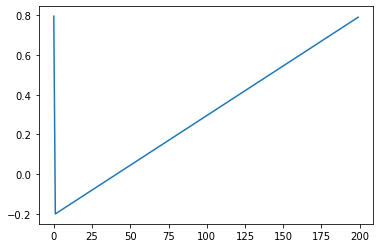

In [14]:
plt.plot(val_buffer.trajectories[3][-1][:, 1])

## Now can we learn to predict without the ground truth labels?

In [15]:
def train_osi_pred(env, train_buffer, val_buffer, h, d_latent=2):
    osi_d_in = 2 * env.model.nq # qpos, qvel
    osi_d_param = d_latent # TODO: this could be more than 2 since we don't have the true labels
    osi_d_hidden_shared = 128
    osi_d_hidden_osi = 512

    osi_model = OSI(h, osi_d_in, osi_d_param, osi_d_hidden_shared, osi_d_hidden_osi)
    
    pred_d_in = 5 +  osi_d_param
    pred_d_out = 4 # qpos, qvel
    pred_d_hidden = 256
    
    pred_model = nn.Sequential(
        nn.Linear(pred_d_in, pred_d_hidden),
        nn.ReLU(),
        nn.Linear(pred_d_hidden, pred_d_hidden),
        nn.ReLU(),
        nn.Linear(pred_d_hidden, pred_d_hidden),
        nn.ReLU(),
        nn.Linear(pred_d_hidden, pred_d_out)
    )
    
    lr = 5e-4
    batch_size = 64
    n_iters = 20000
    print_iter = 250

    osi_model = osi_model.to(device)
    pred_model = pred_model.to(device)

    optim = torch.optim.Adam(list(osi_model.parameters()) + list(pred_model.parameters()), lr=lr)

    for i in range(n_iters):
        batch = train_buffer.get_traj_batch(batch_size, h)
        x_osi, y_osi = buffer_to_osi_torch(batch)
        x_pred, y_pred, x_prev_pred, fov_pred = traj_buffer_to_pred_torch(batch)
        
        x_osi, y_osi = x_osi.to(device), y_osi.to(device)
        x_pred, y_pred, x_prev_pred, fov_pred = x_pred.to(device), y_pred.to(device), x_prev_pred.to(device), fov_pred.to(device)
        
        optim.zero_grad()
        
        est_params = osi_model(x_osi)
        x_in = torch.cat([x_pred, est_params], dim=1)
        
        delta = pred_model(x_in)
        y_hat = x_prev_pred + delta

        loss = F.mse_loss(y_hat, y_pred)
        loss.backward()
        optim.step()

        if i % print_iter == 0:
            val_batch = train_buffer.get_traj_batch(128, h)
            x_osi_val, y_osi_val = buffer_to_osi_torch(batch)
            x_pred_val, y_pred_val, x_prev_pred_val, fov_pred_val = traj_buffer_to_pred_torch(batch)

            x_osi_val, y_osi_val = x_osi_val.to(device), y_osi_val.to(device)
            x_pred_val, y_pred_val, x_prev_pred_val, fov_pred_val = x_pred_val.to(device), y_pred_val.to(device), x_prev_pred_val.to(device), fov_pred_val.to(device)

            est_params_val = osi_model(x_osi_val)
            x_in_val = torch.cat([x_pred_val, est_params_val], dim=1)

            delta_val = pred_model(x_in_val)
            y_hat_val = x_prev_pred_val + delta_val

            val_loss = F.mse_loss(y_hat, y_pred)
            print(i, loss.item(), val_loss.item())
    return osi_model, pred_model

In [16]:
d_latent = 4
osi_model_joint, pred_model_joint = train_osi_pred(env, train_buffer, val_buffer, h, d_latent=d_latent)

0 0.0026811622083187103 0.0026811622083187103
250 1.7655938790994696e-05 1.7655938790994696e-05
500 1.3452666962621151e-06 1.3452666962621151e-06
750 2.1691123492928455e-06 2.1691123492928455e-06
1000 8.768424208938086e-07 8.768424208938086e-07
1250 8.402882940572454e-07 8.402882940572454e-07
1500 1.4805086721025873e-06 1.4805086721025873e-06
1750 1.4804693364567356e-06 1.4804693364567356e-06
2000 1.0608497404973605e-06 1.0608497404973605e-06
2250 1.4160747241476201e-06 1.4160747241476201e-06
2500 1.2483822047215654e-06 1.2483822047215654e-06
2750 1.2667294413404306e-06 1.2667294413404306e-06
3000 5.587359623859811e-07 5.587359623859811e-07
3250 3.0487339586215967e-07 3.0487339586215967e-07
3500 7.565745363535825e-07 7.565745363535825e-07
3750 9.618295280233724e-07 9.618295280233724e-07
4000 3.875410925502365e-07 3.875410925502365e-07
4250 5.921282308918308e-07 5.921282308918308e-07
4500 1.032562181535468e-06 1.032562181535468e-06
4750 9.755324299476342e-07 9.755324299476342e-07
5000 5

In [17]:
pos_mse_osi, fov_mse = eval_osi_pred(osi_model, pred_model_gt, val_buffer, h)
pos_gt_mse = eval_pred_gt(pred_model_gt, val_buffer)
pos_no_fov_mse = eval_pred_gt(pred_model_no_fov, val_buffer, include_fov=False)
joint_mse_osi = eval_osi_pred(osi_model_joint, pred_model_joint, val_buffer, h, calc_fov=False)

print(pos_mse_osi, pos_gt_mse, pos_no_fov_mse, joint_mse_osi)

4.5111886493032216e-07 3.499540355278441e-07 1.4050422578293364e-05 2.7178907657798845e-07


### Can we recover the rotations from the latents?

In [18]:
def train_latents_to_fov(osi_model, train_buffer, val_buffer, h, d_latent=2):
    d_in = d_latent
    d_out = n_fov
    d_hidden = 32
    
    lr = 5e-4
    batch_size = 64
    n_iters = 20000
    print_iter = 100

    model = nn.Sequential(
        nn.Linear(d_in, d_hidden),
        nn.ReLU(),
        nn.Linear(d_hidden, d_hidden),
        nn.ReLU(),
        nn.Linear(d_hidden, d_hidden),
        nn.ReLU(),
        nn.Linear(d_hidden, d_out)
    )
    
    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(n_iters):
        batch = train_buffer.get_traj_batch(batch_size, h)
        x, y = buffer_to_osi_torch(batch)
        x, y = x.to(device), y.to(device)
        
        optim.zero_grad()
        latent = osi_model(x)
        
        y_hat = model(latent)

        loss = F.mse_loss(y_hat, y)
        loss.backward()
        optim.step()

        if i % print_iter == 0:
            val_batch = val_buffer.get_traj_batch(128, h)
            x_val, y_val = buffer_to_osi_torch(val_batch)
            x_val, y_val = x_val.to(device), y_val.to(device)
            latent_val = osi_model(x_val)
            y_hat_val = model(latent_val)
            val_loss = F.mse_loss(y_hat_val, y_val)
            print(i, loss.item(), val_loss.item())
    return model

In [19]:
latent_fov_model = train_latents_to_fov(osi_model, train_buffer, val_buffer, h, d_latent=d_latent)

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
def eval_latent_to_fov(osi_model, fov_model, buffer, h, val_size=5000):
    batch = buffer.get_traj_batch(val_size, h)
    x, y = buffer_to_osi_torch(batch)
    x, y = x.to(device), y.to(device)
    latent = osi_model(x)
    y_hat = fov_model(latent)
    loss = F.mse_loss(y_hat, y)
    return loss.item()

def visual_eval_latent_to_fov(osi_model, fov_model, buffer, h):
    batch = buffer.get_traj_batch(4, h)
    x, y = buffer_to_osi_torch(batch)
    x, y = x.to(device), y.to(device)
    latent = osi_model(x)
    y_hat = fov_model(latent)
    print(y.detach().cpu().numpy())
    print(y_hat.detach().cpu().numpy())

In [ ]:
eval_loss = eval_latent_to_fov(osi_model, latent_fov_model, val_buffer, h)
print(eval_loss)
visual_eval_latent_to_fov(osi_model, latent_fov_model, val_buffer, h)
